In [152]:
%run "data_preprocess.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total

In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

On macs, GPU is not available so by default we're using cpu

In [154]:
device = torch.device("cpu")
device

device(type='cpu')

Lets Split the dataset in training and testing

In [155]:
X = df.drop(columns=["Exited"])
y = df["Exited"]
print(X.columns)
y.head

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')


<bound method NDFrame.head of 0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64>

Scale our data

In [156]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

column_transformer = ColumnTransformer([
    # ('min_max_scaler', MinMaxScaler(), []),
    ('standard_scaler', StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Geography', 'NumOfProducts', 'Gender', 'HasCrCard', 'IsActiveMember'])
])

X = column_transformer.fit_transform(X)
y = MinMaxScaler().fit_transform(y.values.reshape(-1 , 1))

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=41, shuffle=True)
print(X_train.shape)
y_train.shape

(7000, 10)


(7000, 1)

We must convert np arrays to tensors for modelling in PyTorch

In [218]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print("Data type : ", type(X_test))

Data type :  <class 'torch.Tensor'>


In [219]:
print("X_train size : ", X_train.data.size())
print("y_train size : ", y_train.data.size())
print("X_test size : ", X_test.data.size())
print("y_test size : ", y_test.data.size())

X_train size :  torch.Size([6000, 10])
y_train size :  torch.Size([6000, 1])
X_test size :  torch.Size([2000, 10])
y_test size :  torch.Size([2000, 1])


10 columns from above cell means we have got 10 input features. Output col = 1

Defining out neural network!

In [246]:
class NeuralNet(nn.Module):
    def __init__(self, ip_feat = 10, l1 = 30, l2=55, l3=30, op_feat=1):
        super().__init__()
        self.layer_one = nn.Linear(ip_feat, l1)
        self.layer_two = nn.Linear(l1, l2)
        self.layer_three = nn.Linear(l2, l3)
        self.output_layer = nn.Linear(l3, op_feat)
        
        self.dropout = nn.Dropout(0.25)
        
        
    def forwardProp(self, x):
        x = nn.functional.relu(self.layer_one(x))
        x = nn.functional.relu(self.layer_two(x))
        x = nn.functional.relu(self.layer_three(x))
        x = self.dropout(x)
        x = nn.functional.sigmoid(self.output_layer(x))
        
        y = x
        return y 
        

Config : Set up the Hyperparameters

In [255]:
torch.manual_seed(41)
learning_rate = 0.001
epochs = 350

Set up Loss function and optimizer

In [256]:
network = NeuralNet()
loss_func = nn.BCELoss()
losses_train = []
losses_test = []
acc_train = []
acc_test_li = []
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

Train the model

In [257]:

def binary_accuracy(y_pred, y_true):
    y_pred_tag = (y_pred>0.5).float()
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum/y_true.shape[0]
    return acc * 100

import wandb  #future reference

for i in range(epochs):
    y_pred_train= network.forwardProp(X_train)
    loss_train = loss_func(y_pred_train, y_train)
    losses_train.append(loss_train.detach().numpy())
    
    
    acc = binary_accuracy(y_pred_train, y_train)
    acc_train.append(acc)
    
    #Backpropotion for training
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    #----------test------------
    with torch.no_grad():
        y_pred_test = network.forwardProp(X_test)
        loss_test = loss_func(y_pred_test, y_test)
        losses_test.append(loss_test.detach().numpy())
        
        acc_test = binary_accuracy(y_pred_test, y_test)
        acc_test_li.append(acc_test)
    
    print(f"Epoch = {i} \t Loss-train = {loss_train} \t loss-test = {loss_test} \t Accuracy-train = {acc} \t accuracy-test = {acc_test}")
        


Epoch = 0 	 Loss-train = 0.7604158520698547 	 loss-test = 0.7559435963630676 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.25
Epoch = 1 	 Loss-train = 0.7557559609413147 	 loss-test = 0.7506360411643982 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.25
Epoch = 2 	 Loss-train = 0.7503824830055237 	 loss-test = 0.745596170425415 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.25
Epoch = 3 	 Loss-train = 0.7457404732704163 	 loss-test = 0.7408825755119324 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.25
Epoch = 4 	 Loss-train = 0.7412153482437134 	 loss-test = 0.7365806698799133 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.299999237060547
Epoch = 5 	 Loss-train = 0.7362635135650635 	 loss-test = 0.7315040230751038 	 Accuracy-train = 20.350000381469727 	 accuracy-test = 20.399999618530273
Epoch = 6 	 Loss-train = 0.7318841218948364 	 loss-test = 0.7274423241615295 	 Accuracy-train = 20.366666793823242 	 accuracy-test = 20.39999

Before Dropout

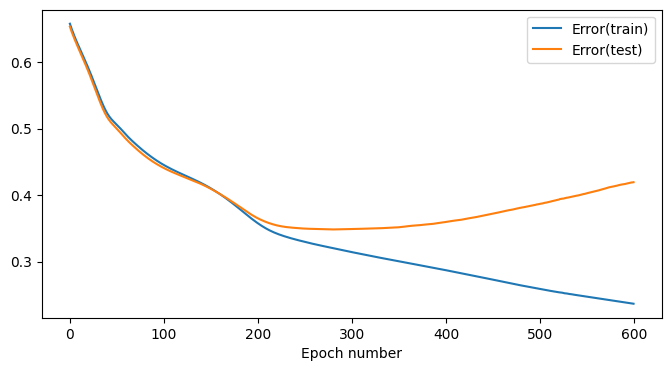

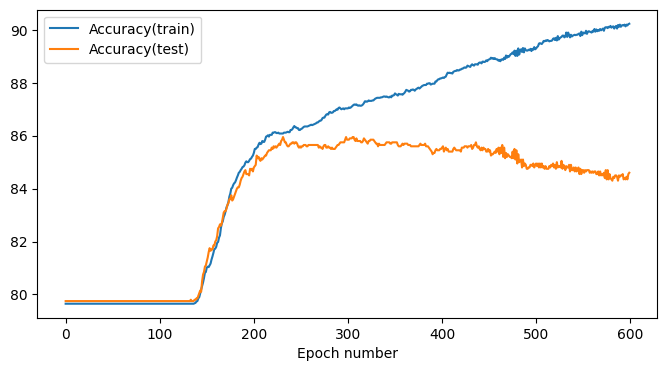

In [239]:
import matplotlib.pyplot as plt 
%matplotlib inline
# Plot the change in the testing and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(losses_train, label='Error(train)')
ax_1.plot(losses_test, label='Error(test)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the testing and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
ax_2.plot(acc_train, label='Accuracy(train)')
ax_2.plot(acc_test_li, label='Accuracy(test)')
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
plt.show()

After Dropout

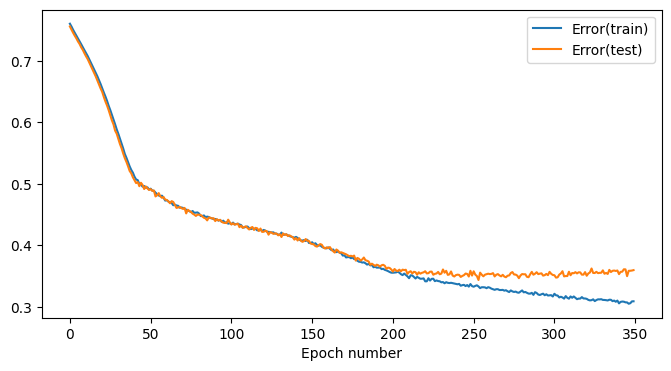

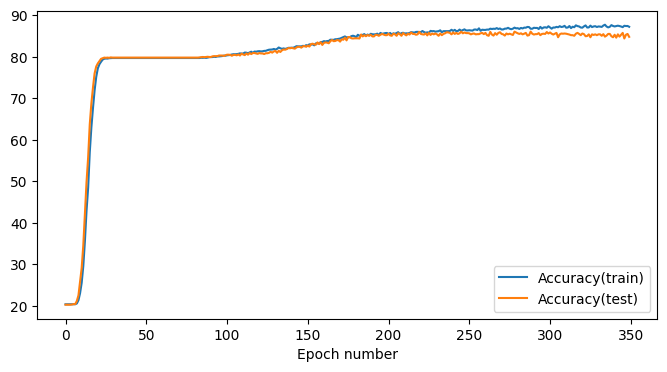

In [258]:
import matplotlib.pyplot as plt 
%matplotlib inline
# Plot the change in the testing and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(losses_train, label='Error(train)')
ax_1.plot(losses_test, label='Error(test)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the testing and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
ax_2.plot(acc_train, label='Accuracy(train)')
ax_2.plot(acc_test_li, label='Accuracy(test)')
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
plt.show()